# Heat transfer simulation

In [1]:
import festim as F
import numpy as np

my_model = F.Simulation()

my_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 1, num=1000)
)

my_model.materials = F.Material(id=1, D_0=1, E_D=0.2, thermal_cond=2)


my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=[1, 2],
        value=1,
        field=0
        )
]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False
    )

The boundary conditions of our heat transfer problem are:

$ T = 300 $    on the left surface

$-\lambda \nabla T \cdot n = h (T - T_\mathrm{ext})$   on the right surface

We will also set a volumetric heat source.

In [2]:
my_model.T = F.HeatTransferProblem(transient=False)


my_model.boundary_conditions += [
    F.DirichletBC(surfaces=1, value=300, field="T"),
    F.ConvectiveFlux(h_coeff=1, T_ext=650, surfaces=2)
    ]


my_model.sources = [F.Source(value=1000, volume=1, field="T")]

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


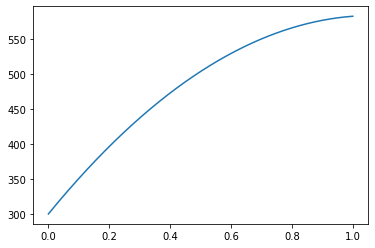

In [3]:
my_model.initialise()
my_model.run()

from fenics import plot

plot(my_model.T.T)